In [3]:
import sys
%load_ext autoreload
sys.path.append('..')

In [4]:
%autoreload 2
from FEMOL import RectangleQuadMesh, FEM_Problem, TOPOPT_Problem, TOPOPT_Results
from FEMOL_utils import *
import timeit
import numpy as np
import matplotlib.animation as animation
from scipy.optimize import fsolve
np.set_printoptions(linewidth=110)
from IPython.display import display, clear_output

ModuleNotFoundError: No module named 'FEMOL'

# Plane Stress Guitar Topology Optimization

## Domain Functions

In [49]:
# Domain functions

def outside_circle(x_pos, y_pos, R):
    
    def circle(x, y):
        
        if (x-x_pos)**2 + (y-y_pos)**2 > R**2:
            return True
        else:
            return False
    
    return circle

def inside_circle(x_pos, y_pos, R):
    
    def circle(x, y):
        
        if (x-x_pos)**2 + (y-y_pos)**2 < R**2:
            return True
        else:
            return False
    
    return circle

def outside_box(x1, x2, y1, y2):
    """
    x1 < x2 & y1 < y2
    """

    def box(x, y):
        
        return ~((x > x1) & (x < x2) & (y > y1) & (y < y2))
    
    return box

def guitar_sides(Lx, Ly):
    angle = np.pi/6
    p = angle/(np.pi/2)
    x1 = 2*Ly/6 + 2*Ly/6 * np.sin(angle)
    y1 = 2*Ly/6 - 2*Ly/6 * np.cos(angle)
    x2 = Lx - Ly/4 - Ly/4 * np.sin(angle)
    y2 = 2*Ly/6 - Ly/4 * np.cos(angle)
    a, b, c, d = create_polynomial(x1, y1, x2, y2, p)
    
    def sides(x, y):
        Y_val = a*x**3 + b*x**2 + c*x + d
        return ~((x > x1) & (x < x2) & (y > Y_val) & (y < -Y_val+Ly))

    return sides

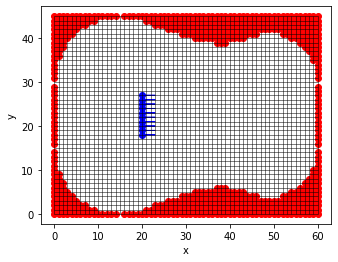

In [51]:
# Initialise the problem
FEM_Guitar = FEM_Problem(mesh)

# Materials
Base = general_flax()
Brace = general_carbon()

# Layups
# Composite material layup
Base_Layup = [0, 0, 0, 0]
coating_layup = [0]

# Element stiffness matrix for coating and base
FEM_Guitar.base_material_Ke(Base, Base_Layup)
FEM_Guitar.coating_material_Ke(Brace, coating_layup)


# Outside domain
circle1 = outside_circle((2*Ly/6), (2*Ly/6), (2*Ly/6))
circle2 = outside_circle((2*Ly/6), (4*Ly/6), (2*Ly/6))
circle3 = outside_circle((Lx-Ly/4) , 2*Ly/6, Ly/4)
circle4 = outside_circle((Lx-Ly/4) , 4*Ly/6, Ly/4)
box1 = outside_box(0, Lx, 2*Ly/6, 4*Ly/6)
sides = guitar_sides(Lx, Ly)
sound_hole = inside_circle(2*Lx/3, Ly/2, Ly/7)

def fixed_guitar(x, y):
    """
    Fixed boundary conditions surrounding the guitar
    """
    if np.array([circle1(x,y), circle2(x,y), circle3(x,y), circle4(x,y), box1(x,y), sides(x, y)]).all():
        return True
    else:
        return False
    
def voided_guitar(x, y):
    """
    Parts where there is no material on the guitar
    """
    if np.array([circle1(x,y), circle2(x,y), circle3(x,y), circle4(x,y), box1(x,y), sides(x, y)]).all():
        return True
    elif sound_hole(x,y):
        return True
    else:
        return False 

x = [Lx/3]
y = [[8*Ly/20, 12*Ly/20]]
force_domain = create_domain(x, y)
force = [[100000, 0]]

FEM_Guitar.add_fixed_domain(fixed_guitar)
FEM_Guitar.add_forces(force, [force_domain])
FEM_Guitar.assemble_coated_material_topopt(np.ones(nelx*nely), 2)
FEM_Guitar.fix_boundary()
FEM_Guitar.plot()

In [1]:
TOPOPT_Guitar = TOPOPT_Problem(FEM_Guitar, volfrac=0.3)
Guitar_0_0 = TOPOPT_Guitar.solve_coating(converge=0.05, void_domain=voided_guitar)

NameError: name 'TOPOPT_Problem' is not defined

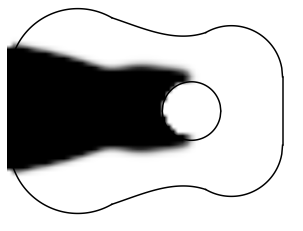

In [53]:
Guitar_0_0.plot()
guitar_outline(Lx, Ly)


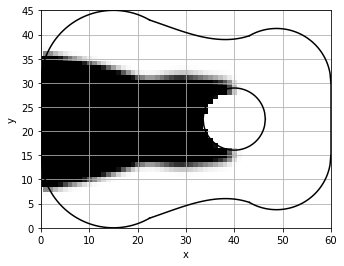

In [60]:
X = Guitar_0_0.X_solutions[-1]
X_final = np.flip(X.reshape(Ly, Lx), axis=0)
plt.imshow(X_final, cmap='Greys')
plt.xlabel('x')
plt.ylabel('y')
plt.ylim(0, Ly)
plt.xlim(0, Lx)
plt.grid('on')
guitar_outline(Lx, Ly)
plt.show()

In [ ]:
Guitar_0_90.animate('guitar-0-90')

In [ ]:
Guitar_0_90.save('guitar')


In [ ]:
TOPOPT_Guitar = TOPOPT_Problem(FEM_Guitar, volfrac=0.1)
Guitar_0_0 = TOPOPT_Guitar.solve_coating(converge=0.05, void_domain=voided_guitar)

In [ ]:
Solutions = np.loadtxt('Plane_Stress_Guitar')